#### Notice
Topography.py provides functions for loading required datasets, such as 

1. the MEaSUREs InSAR-Based Antarctica Ice Velocity Map (Ver 2),
https://nsidc.org/data/nsidc-0484/versions/2

2. Surface Mass Balance provided by RACMO2.3p2,
https://doi.org/10.5194/tc-12-1479-2018
https://www.projects.science.uu.nl/iceclimate/publications/data/2018/vwessem2018_tc/RACMO_Yearly/

3. MEaSUREs ITS_LIVE Antarctic Grounded Ice Sheet Elevation Change (Ver 1),
https://nsidc.org/data/nsidc-0782/versions/1

4. and BedMachine Antarctica Topography.
https://nsidc.org/data/nsidc-0756/versions/3

These functions are used for conveniently loading datasets for subglacial topography inversion purpose. However, they are not generally applicable to other datasets or the above datasets if they changed their format after 2025. This tutorial demonstrates how to load those dataset through functions in Topography.py.

# Tutorial 1: Loading and Visualizing Ice Stream Data

Let's first import libraries used in this jupyter lab. Notice that prerequired libraries in gstatsMCMC must be installed even if they are not imported in the jupyter notebook interface here

__Make sure the Topography.py is in the same folder as this jupyter notebook, otherwise you may need to modify the import__

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gstatsMCMC import Topography
import xarray as xr
import verde as vd

In [2]:
import geopandas as gpd

In [3]:
import gstatsim as gs

In [29]:
# Defining polygon
from shapely.geometry import Point, Polygon
from matplotlib.path import Path
from pyproj import Proj, Transformer
from matplotlib.patches import Polygon as MplPolygon

First, lets decides a region in Antarctic that we are interested in

__Q1: Where is your glacier? What is the boundary of this glacier in polar stereographic coordinate? Answer the question and then modify the code as needed__

Answer: According to https://bedmap.scar.org/, Pine Island Glacier is located at -1595755.76076, -281374.795243. However, upon looking at the ice velocity data, the true size of the study region is much larger than what is depicted on the website.

In [4]:
# Change the following coordinate based on your studying region
# make sure the coordinate ends with 250 or 750 to match up with pre-compiled radar data

xmin = -1800250
xmax = -1100250 
ymax = 30250
ymin = -400250

In [5]:
# Determine the resolution of the topography map

resolution = 500

In [6]:
xx, yy = np.meshgrid(np.arange(xmin, xmax, resolution), 
                     np.arange(ymin, ymax, resolution))

In [7]:
# This is the shape of your study region
xx.shape

(861, 1400)

In [8]:
data = {'x': xx.flatten(),
        'y': yy.flatten()}
df = pd.DataFrame(data)
df

,x,y
0,-1800250,-400250
1,-1799750,-400250
2,-1799250,-400250
3,-1798750,-400250
4,-1798250,-400250
...,...,...
1205395,-1102750,29750
1205396,-1102250,29750
1205397,-1101750,29750
1205398,-1101250,29750


### First, lets load the surface elevation of your Glacier

NOTICE! The region mask in bedmap will automatically be interpolated using nearest neighbor interpolation method


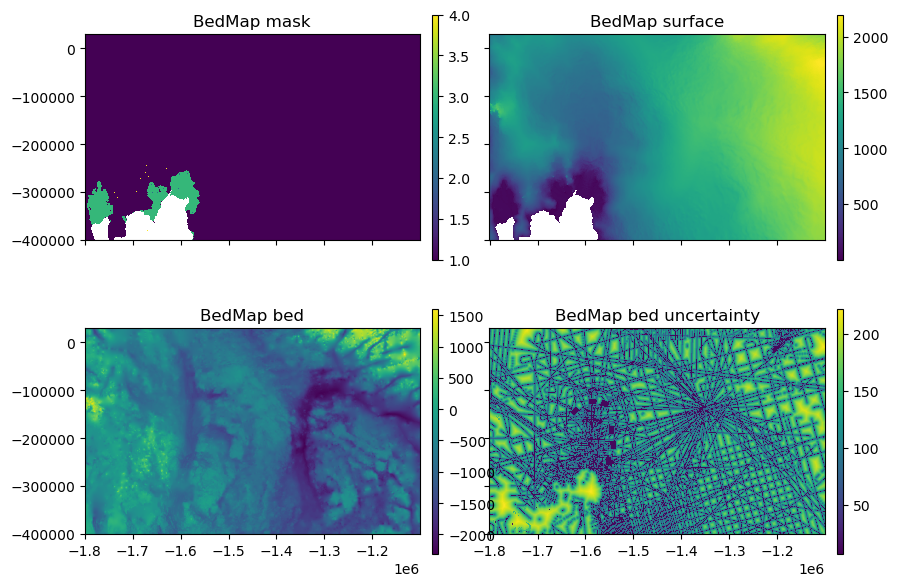

In [9]:
bedmap_mask, bedmap_surf, bedmap_bed, bedmap_bed_uncertainty, fig = Topography.load_bedmap("DEMOGORGN data/bedmap3.nc", 
                                                                                xx, yy, resolution)
fig

In [10]:
df['surf'] = bedmap_surf.flatten()

In [11]:
df

,x,y,surf
0,-1800250,-400250,646.0
1,-1799750,-400250,637.0
2,-1799250,-400250,631.0
3,-1798750,-400250,624.0
4,-1798250,-400250,616.0
...,...,...,...
1205395,-1102750,29750,1818.0
1205396,-1102250,29750,1816.0
1205397,-1101750,29750,1814.0
1205398,-1101250,29750,1815.0


### Next, lets load the pre-compiled ice thickness measured by ice-penetrating radar.

In [12]:
xmin_ant = -3333250
xmax_ant = 3333250
ymin_ant = -3333250
ymax_ant = 3333250

xx_ant, yy_ant = np.meshgrid(np.arange(xmin_ant, xmax_ant + resolution, resolution), 
                     np.arange(ymin_ant, ymax_ant + resolution, resolution))

In [13]:
xmin_ind = np.where(xx_ant == xmin)[1][0]
xmax_ind = np.where(xx_ant == xmax)[1][0]
ymin_ind = np.where(yy_ant == ymin)[0][0]
ymax_ind = np.where(yy_ant == ymax)[0][0]

In [14]:
# replace with the directory of your downloaded data

radar_thickness = np.load('DEMOGORGN data/bedmap3_raw_thick_compilation.npy')
radar_thickness = np.flip(radar_thickness,axis=0)
radar_thickness = radar_thickness[ymin_ind:ymax_ind,xmin_ind:xmax_ind]

(-1800500.0, -1100500.0, -400500.0, 30000.0)

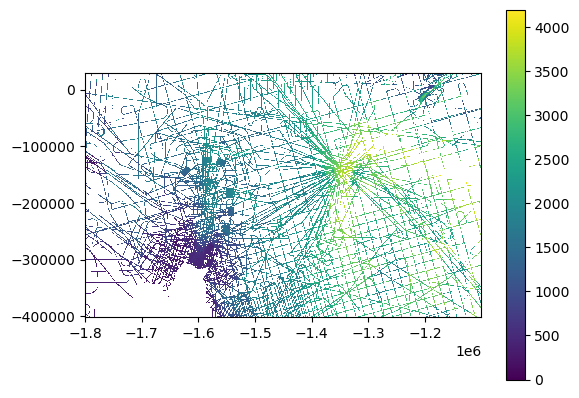

In [15]:
plt.pcolormesh(xx,yy,radar_thickness)
plt.colorbar()
plt.axis('scaled')

(-1800500.0, -1100500.0, -400500.0, 30000.0)

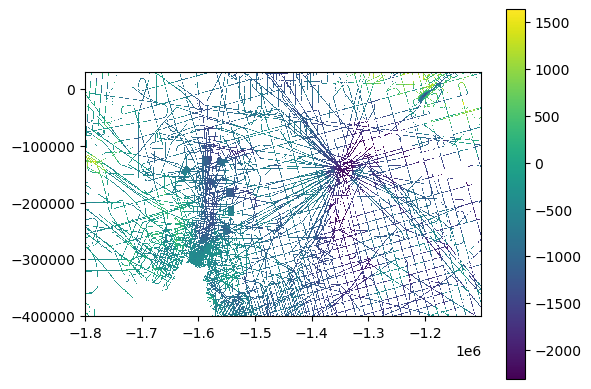

In [16]:
plt.pcolormesh(xx,yy,df['surf'].values.reshape(xx.shape) - radar_thickness)
plt.colorbar()
plt.axis('scaled')

### Then we can load other data needed

Please refers to the document of the library to findout what to fill in each argument of the method. Feel free to contact your TA if you encountered any problem

loading InSAR_MEaSUREs velocity dataset


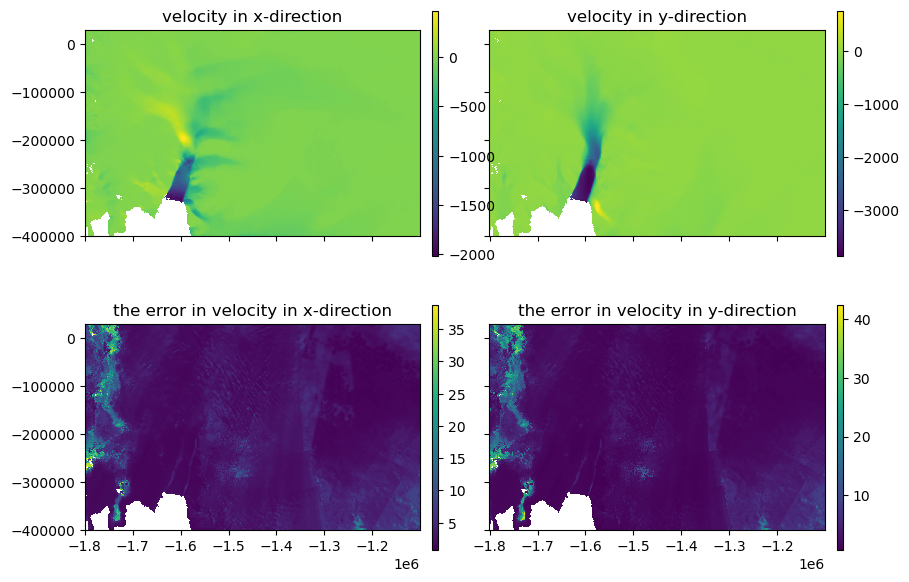

In [17]:
print('loading InSAR_MEaSUREs velocity dataset')
velx, vely, velxerr, velyerr, figvel = Topography.load_vel_measures('DEMOGORGN data/antarctica_ice_velocity_450m_v2.nc', 
                                                                    xx, yy, resolution)
figvel

In [18]:
vel_mag = np.sqrt(velx**2 + vely**2)

(-1800500.0, -1100500.0, -400500.0, 30000.0)

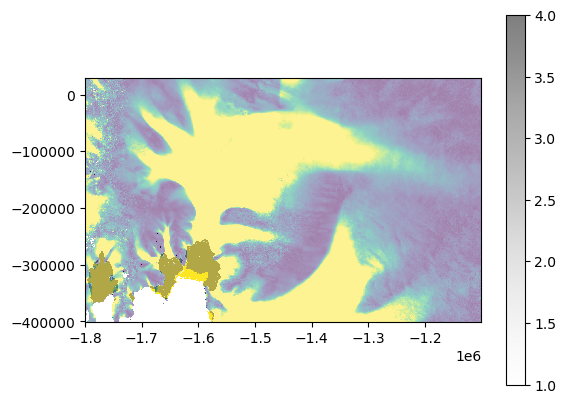

In [19]:
plt.pcolormesh(xx,yy,vel_mag,vmax=50)
plt.pcolormesh(xx,yy,bedmap_mask, alpha = 0.5, cmap='Grays')
plt.colorbar()
plt.axis('scaled')

load_dhdt returns annual average of surface elevation change

__Q2: What time period did you choose for loading this dataset? Why? How the data change if you choose other time periods?__

Answer: 2014-July 2016; this is because sufficient data was available for my glacier, and keeping a relatively consistent, recent time frame among students is valuable in ensuring the current application of the data.

loading height change rate dataset


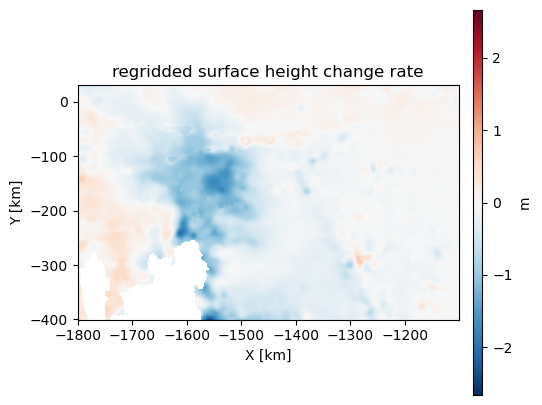

In [20]:
print('loading height change rate dataset')
dhdt, figdhdt = Topography.load_dhdt('DEMOGORGN data/ANT_G1920_GroundedIceHeight_v01.nc',xx,yy,resolution,
                                     interp_method='linear',begin_year=2014,end_year=2016,month=7)
figdhdt

__Notice! This function load for yearly surface mass balance. Does the year here match with the year you used for surface elevation?__

loading racmo dataset


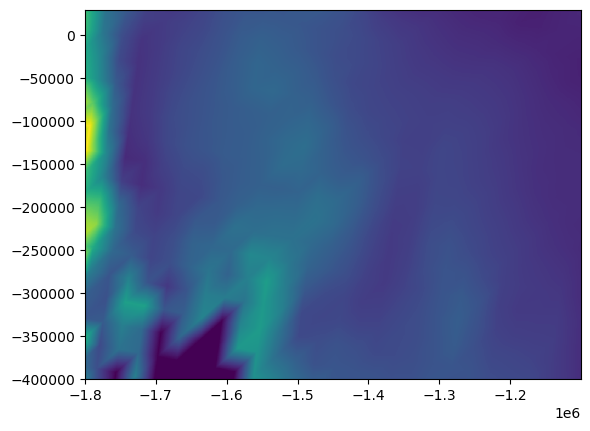

In [21]:
print('loading racmo dataset')   
smb2014, fig1 = Topography.load_smb_racmo('DEMOGORGN data/SMB_RACMO2.3p2_yearly_ANT27_1979_2016.nc', xx, yy, resolution, interp_method='linear',time=2014)
smb2015, fig2 = Topography.load_smb_racmo('DEMOGORGN data/SMB_RACMO2.3p2_yearly_ANT27_1979_2016.nc', xx, yy, resolution, interp_method='linear',time=2015)
smb2016, fig3 = Topography.load_smb_racmo('DEMOGORGN data/SMB_RACMO2.3p2_yearly_ANT27_1979_2016.nc', xx, yy, resolution, interp_method='linear',time=2016)
smb = (smb2014 + smb2015 + smb2016)/3
plt.pcolormesh(xx,yy,smb)

(-1800500.0, -1100500.0, -400500.0, 30000.0)

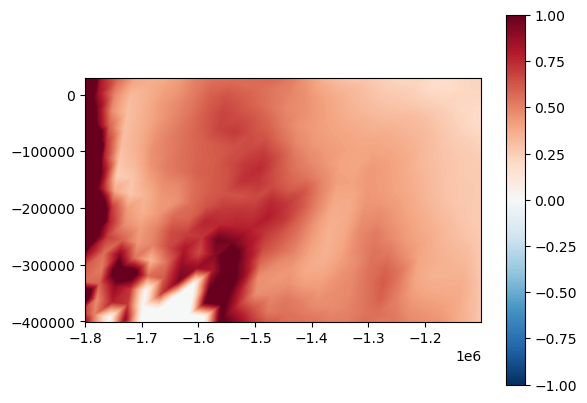

In [22]:
plt.pcolormesh(xx,yy,smb,vmax=1, vmin=-1, cmap='RdBu_r')
plt.colorbar()
plt.axis('scaled')

BedMachine use a different geoid compared to BedMap, so if you want to compare bed topography or surface elevation between BedMachine and Bedmap, geoid conversion need to be done. 

But if you are just comparing the thickness, there is no need for geoid conversion. We use this little trick here to obtain ice thickness information from BedMachine instead

loading BedMachine dataset
NOTICE! The categorical data in bedmachine will automatically be interpolated using nearest neighbor interpolation method


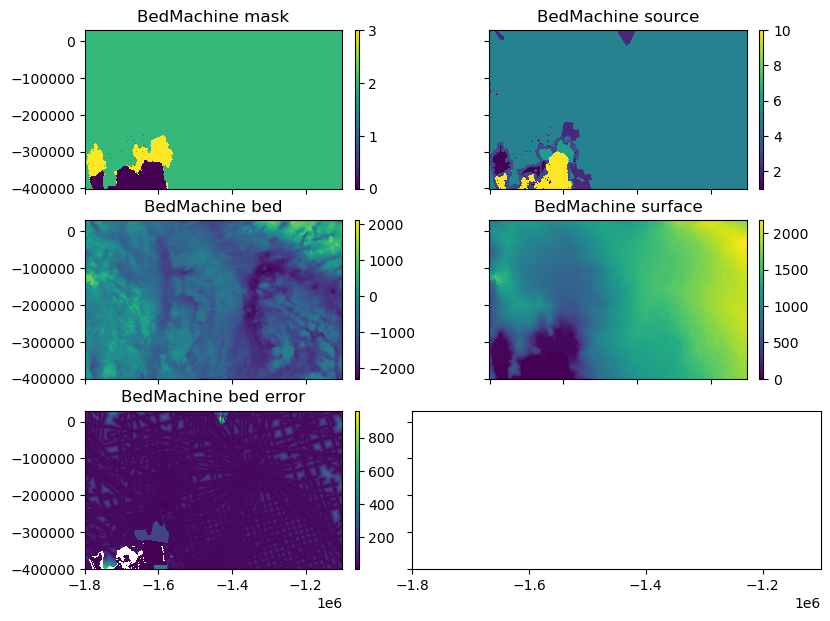

In [23]:
print('loading BedMachine dataset')
bm_mask, bm_source, bm_bed, bm_surface, bm_errbed, figbm = Topography.load_bedmachine('DEMOGORGN data/BedMachineAntarctica-v3.nc', xx, yy, resolution)
figbm

In [24]:
bm_thickness = bm_surface - bm_bed

__How will you interpret the data loaded?__

__Have you noticed any data that have gaps inside the region? Do you have any guesses why those gaps exists?__

A: Gaps in data may exist because no data collection occurred during that year. Moreover, some gaps may exist due to errors in data collection.

These gaps could affect the calculation of ice flux residuals in the later tutorial. If the gaps exist, please try to load data from other datasets or consistently change the reference time, until you have found surface ice velocity, surface mass balance, and surface elevation change that covers the entire region

### Lets determine the high-velocity region, where we want to apply MCMC algorithm

In addition, since we have the velocity data, it will also be nice to know where the high velocity region is, remembering that the mass conservation technique is best applied in high velocity region

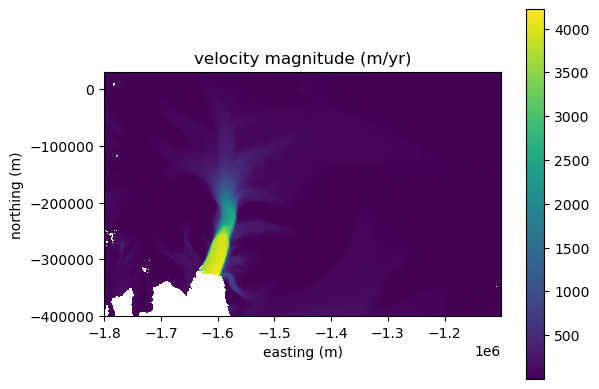

In [25]:
# calculate velocity magnitude
vel_mag = np.sqrt(velx**2 + vely**2)

# Plot the velocity magnitude
plt.pcolormesh(xx,yy,vel_mag)
plt.colorbar()
plt.axis('scaled')
plt.title('velocity magnitude (m/yr)')
plt.xlabel('easting (m)')
plt.ylabel('northing (m)')
plt.show()

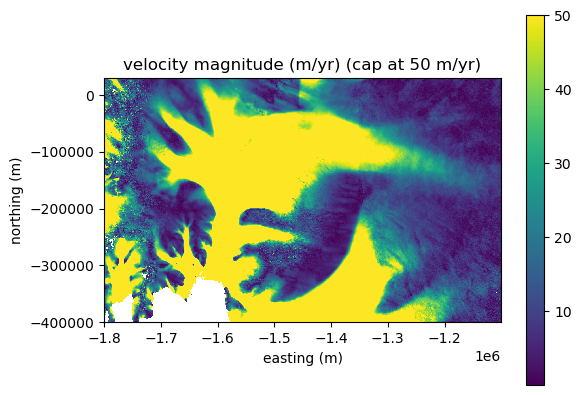

In [26]:
# calculate velocity magnitude
vel_mag = np.sqrt(velx**2 + vely**2)

# Plot the velocity magnitude
plt.pcolormesh(xx,yy,vel_mag, vmax=50)
plt.colorbar()
plt.axis('scaled')
plt.title('velocity magnitude (m/yr) (cap at 50 m/yr)')
plt.xlabel('easting (m)')
plt.ylabel('northing (m)')
plt.show()

The *highvel_mask* returned try to smoothly enclose a region of high velocity and excluding locations where the ice is not grounded. This region could be used later to constrain the sampling location of the MCMC.

The function works as first find high velocity region, then smooth the boundary of this region. Because this smoothing generally will shrink the boundary, the boundary is later expanded outward for *distance_max* meters.

The degree of smoothness of the boundary could be modified by the optional argument *smooth_mode*, which is default to 10. A higher smooth_mode will give a smoother boundary

The *ocean_mask* will be 1 when the location is ocean (open ocean water without ice, sea ice, or ice shelf), and will be 0 otherwise.

The *grounded_ice_mask* is 1 at location where ice is present and grounded, and will be 0 otherwise.

An example where *ocean_mask == 0 and grounded_ice_mask == 0* will be ice-free terrestrial land

__Q3: Change distance_max and smooth_mode parameters, how do you see the high velocity region changed by these parameter? Which parameter give a reasonable answer?__

Answer: Increasing the smooth_mode parameter makes some areas more smooth than necessary, and fails to show some areas with the appropriate detail to accurately depict the true scope of the high velocity region. The initial parameter gives a reasonable answer (distance_max = 3500, smooth_mode = 18). 

Notice, we aims to cover region with 50 m/yr velocity magnitude

In [28]:
# calculate high velocity region
ocean_mask = (bedmap_mask == 3) | (np.isnan(bedmap_mask)) # utilize the mask in BedMachine dataset to characterize ice regions
grounded_ice_mask = (bedmap_mask == 1) | (bedmap_mask == 2)
distance_max = 3500
velocity_threshold = 50
smooth_mode = 30 # 10 - 25
highvel_mask = Topography.get_highvel_boundary(velx, vely, velocity_threshold, grounded_ice_mask, ocean_mask, 
                                               distance_max, xx, yy, smooth_mode = smooth_mode)

In [30]:
poly_pi = [(-1110250, -157750), (-1350250, -157750), (-1425250, -307750), (-1515250, -395750), (-1624250, -365750), (-1684250, -375750),
           (-1728250, -255750), (-1748250, 30250), (-1500250, 30250), (-1450750, 0), (-1400250, 30250), (-1110250, 30250)]
path_final = Path(poly_pi)
points = np.vstack((xx.flatten(), yy.flatten())).T
mask_polygon = path_final.contains_points(points).reshape(xx.shape)
final_mask = highvel_mask & mask_polygon

### Reserved this space for sanity check. 
Have you visualize every data loaded? Do they look realistic? Has interpolating data give back artifacts? Is there any bed elevation measurement higher than elevation of ice surface?

### Save the loaded data

save the gridded radar data

In [31]:
df['bed'] = df['surf'].values - radar_thickness.flatten()

df['velx'] = velx.flatten()
df['vely'] = vely.flatten()
df['smb'] = ((smb2014 + smb2015 + smb2016)/3).flatten()
df['dhdt'] = dhdt.flatten()

df['final_mask'] = final_mask.flatten()

df['bedmap_mask'] = bedmap_mask.flatten()
df['bedmap_surf'] = bedmap_surf.flatten()
df['bedmachine_source'] = bm_source.flatten()
df['bedmachine_thickness'] = bm_thickness.flatten()
df['bedmap_bed'] = bedmap_bed.flatten()

In [32]:
#Yay! Now just change the glacier name to your glacier
df.to_csv('PineIslandGriddedMASKED.csv', index = False)

### Optional! Do not recommend to run in class

This is only for reference, in case if you are interested in how the radar data were compiled. Takes a long time and large storage space to run.

Please check with bedmap3 website and __download all the bed elevation measurements data into one folder__. Let's call that folder *radar_folder*.

In [30]:
# Change the radar_folder to the directory of the downloaded radar data
radar_folder = '../Data/radarTest'
output_file_name = '../Data/compiledRadar.csv'

Loading radar dataset

In [31]:
df, df_out, fig = Topography.load_radar(radar_folder, output_file_name, include_only_thickness_data=False)

FileNotFoundError: the folder_path provided is not a directory

In [ ]:
df

In [ ]:
fig

gridding radar data

In [ ]:
df=df[(df['x']>=xmin) & (df['x']<=xmax) & (df['y']>=ymin) & (df['y']<=ymax)] # find all radar data inside the domain
df_grid, grid_matrix, rows, cols = Topography.grid_data(df, 'x', 'y', 'bed', resolution, xmin, xmax, ymin, ymax) # grid them
df_grid = df_grid.rename(columns = {"Z": "bed"})

x_uniq = np.unique(df_grid.X)
y_uniq = np.unique(df_grid.Y)

xx, yy = np.meshgrid(x_uniq, y_uniq) # xx store the x coordinate of every location on this 2D map. Similarly, yy store y coordinate
xx.shape

In [ ]:
df_grid

In [ ]:
plt.pcolormesh(xx,yy,df_grid['bed'].values.reshape(xx.shape))
plt.colorbar()
plt.axis('scaled')
plt.title('gridded radar measurements')